In [56]:
import json
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
import pandas as pd
from sklearn.model_selection import GridSearchCV
from typing import Any
import spacy
from spacy.lang.de.stop_words import STOP_WORDS

%matplotlib inline
# nlp = spacy.load('de')


# Classifiers
SGD = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3,
                    random_state=42, max_iter=5, tol=None)
MNB = MultinomialNB()
LR = LogisticRegression()
SVC = LinearSVC()

# Load Glyphboard data as test
# 3 = Event, 4 = Music


def getTestData():
    with open("test_data.json", "r") as read_file:
        test_data = json.load(read_file)
    test_texts = []
    test_labels = []
    for doc in test_data:
        # only use confident labels
        if (doc["features"]["1"]["4"] > 0.8):
            test_labels.append(1)
            test_texts.append(doc["values"]["7"])
        elif (doc["features"]["1"]["4"] < 0.2):
            test_labels.append(0)
            test_texts.append(doc["values"]["7"])
    return pd.DataFrame({'text': test_texts, 'label': test_labels})


def main():
    print('test')
    # doc = nlp('Hallo, dies ist ein Test, yay!')
    # print(doc[0].text)
    metricsLR = createMetrics(SVC)
    # pd.DataFrame({'LR': metricsLR.f1}).plot(figsize=(15, 5))


def handleNewAnswer(answer):
    texts = []
    labels = []
    text = answer['text']
    print(answer)
    with open(
            "training_data.csv", "a+", newline="", encoding="utf8", errors='ignore') as file:
        writer = csv.writer(file, delimiter=';')
        # preprocessText(text)
        writer.writerow([text, answer["questionId"], answer["answer"]])
        file.close()

    with open(
            "training_data.csv", "r", encoding="utf8") as file:
        reader = csv.reader(file, delimiter=';')
        counter = sum(1 for row in reader)
        next(reader, None)  # Skip header
        for line in reader:
            texts.append(line[0])
            labels.append(int(line[2]))
        # Require 10 labels before training
        if counter > 10:
            return train(texts, labels, algo=MNB)
        else:
            return ''


def createMetrics(algo):
    test_data = getTestData()
    train_data_df = pd.read_csv("training_data.csv", sep=";")
    train_data_df.label = train_data_df.label.astype(int)
    met = []
    # Create stepwise metrics algo, simulating a history
    for number in range(30, len(train_data_df)):
        train_data_iteration = train_data_df.head(number)
        met.append(train(train_data_iteration, test_data, algo=algo))
    return pd.DataFrame(met)


def train(train_data, test_data, algo: Any) -> dict:
    # clean_data = [preprocessText(text) for text in data]
    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        # ('nlp', preprocessText())
        # ('clf', LogisticRegression()),
        # ('clf', MultinomialNB()),
        ('clf', algo),
    ])
    text_clf.fit(train_data.text, train_data.label)
    # text_clf.fit(clean_data, labels)
    predicted = text_clf.predict(test_data.text)
    # print(dataframe.prediction.value_counts())
    # print(metrics.classification_report(test_labels, predicted))
    addHistory(metrics.f1_score(test_data.label, predicted))
    result = {
        # 'prediction': predicted.toList(),
        # 'accuracy': metrics.accuracy_score(test_labels, predicted),
        'precision': metrics.precision_score(test_data.label, predicted),
        'recall': metrics.recall_score(test_data.label, predicted),
        'f1': metrics.f1_score(test_data.label, predicted),
        'f1_history': getHistory()
    }
    return result


def getHistory():
    history = []
    with open(
            "metrics.csv", "r", encoding="utf8") as file:
        reader = csv.reader(file, delimiter=';')
        for line in reader:
            history.append(line[0])
        file.close()
    return history


def addHistory(metrics):
    with open(
            "metrics.csv", "a",  newline="", encoding="utf8") as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow([str(metrics)])
        file.close()


# def preprocessText(text: str) -> str:
#     # print('Original: ', text)
#     doc = nlp(text)
#     # Remove Stop Words and get Lemmas
#     return ' '.join([token.text for token in doc if not token.is_stop])
#     # for word in doc:
#     #     if word.is_stop == True:
#     #         print('Stop %s', word)
#     # print(word.lemma_)

#             # Get NER
#     for ent in doc.ents:
#         print(ent.text, ent.start_char, ent.end_char, ent.label_)


# def getDocById(id):
#     for doc in test_data:
#         if id == doc["values"]["2"]:
#             return doc
#     return ''


# def gridSearch(classifier, data, labels):
#     gs_clf = GridSearchCV(classifier, parameters, cv=5, iid=False, n_jobs=-1)
#     gs_clf = gs_clf.fit(data, labels)

#     print(gs_clf.best_score_)
#     print(gs_clf.best_params_)


# main()


In [52]:
test = createMetrics(SVC)

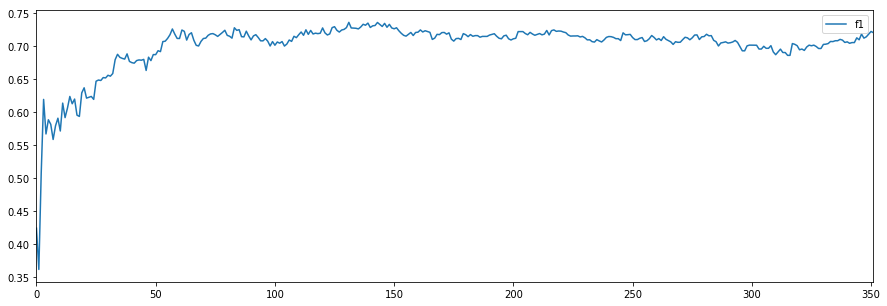

In [57]:
pd.DataFrame({'f1': test.f1}).plot(figsize=(15, 5))